Цель проекта - построение модели, которая бы предсказывала вероятность дефолта клиента в случае выдачи ему кредита.
Исходные данные состоят из исходного датасета train.csv, которая потом была дополнена выгрузкой из БКИ - файлом test.csv.
Структура данных представлена следующими параметрами:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [2]:
#Импортируем необходимые библиотеки:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score,accuracy_score, precision_score,recall_score

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [3]:
# Импортируем данные

data_dir = '/kaggle/input/sf-dst-scoring/'
test = pd.read_csv(data_dir + 'test.csv')
train = pd.read_csv(data_dir + 'train.csv')
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')


1. Объединим данные в один датафрейм. Проблема - в данных test отстутствует значение default. Присвоим значения 0 для этих данных, пометим данные и объединим данные

In [4]:
train['sample'] = 1
test['sample'] = 0
test['default'] = 0

data = train.append(test,ignore_index=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

2. Предобработка. Найдем и заполним пропуски

In [6]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

In [7]:
# Пропуски есть только в education. 
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [8]:
# Заполним пропуски самым популярным значением - SCH. 
data.education = data.education.fillna(data.education.value_counts().index[0])

In [9]:
# Посчитаем количесво уникальных значений в каждом столбце.

cols_dict = {}
for column in data.columns:
    cols_dict[column] = len(data[column].unique())
all_cols = pd.Series(cols_dict).sort_values()
all_cols
    

sample                   2
default                  2
car_type                 2
car                      2
good_work                2
sex                      2
foreign_passport         2
home_address             3
work_address             3
first_time               4
sna                      4
education                5
region_rating            7
decline_app_cnt         24
bki_request_cnt         40
age                     52
app_date               120
income                1207
score_bki           102618
client_id           110148
dtype: int64

In [10]:
# Разделим столбцы по типам данных, исключая default и sample 

bin_cols = list(all_cols[all_cols==2].drop(['default','sample']).index)
cat_cols = list(all_cols[(all_cols>2)&(all_cols<8)].index)
num_cols = list(all_cols[all_cols>8].drop('client_id').index)

print('bin_cols = {}, \ncat_cols = {}, \nnum_cols = {}'.format(bin_cols,cat_cols,num_cols))

bin_cols = ['car_type', 'car', 'good_work', 'sex', 'foreign_passport'], 
cat_cols = ['home_address', 'work_address', 'first_time', 'sna', 'education', 'region_rating'], 
num_cols = ['decline_app_cnt', 'bki_request_cnt', 'age', 'app_date', 'income', 'score_bki']


In [11]:
# Начнем с предобработки бинарных переменных. Переведем все в численные переменные.

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   car_type          110148 non-null  int64
 1   car               110148 non-null  int64
 2   good_work         110148 non-null  int64
 3   sex               110148 non-null  int64
 4   foreign_passport  110148 non-null  int64
dtypes: int64(5)
memory usage: 4.2 MB


In [12]:
# В номерных столбцах необходимо перевести дату в численное значение.
data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   decline_app_cnt  110148 non-null  int64  
 1   bki_request_cnt  110148 non-null  int64  
 2   age              110148 non-null  int64  
 3   app_date         110148 non-null  object 
 4   income           110148 non-null  int64  
 5   score_bki        110148 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.0+ MB


In [13]:
data['app_date'] = pd.to_datetime(data['app_date'])

data['app_month'] = data['app_date'].apply(lambda x: x.month) # Выделим месяц подачи заявки
data['app_day'] = data['app_date'].apply(lambda x: x.weekday()) # День недели подачи заявки
data['app_weekday'] = data['app_date'].apply(lambda x: 
                                             1 if x.weekday() < 5 
                                             else 0) # Рабочий/выходной день

In [14]:
# Добавим в категориальные признаки новые столбцы app_day, app_month:
#cat_cols.append('app_day')
cat_cols.append('app_month')

# Добавим в бинарные признаки новый столбец app_weekday:
bin_cols.append('app_weekday')

# Удалим столбец app_day, так как наша модель не принимает признаки типа datetime
num_cols.remove('app_date')

data.drop('app_date', axis = 1, inplace = True)

In [15]:
# Посчитаем сколько уникальных значений в каждой колонке категориальных признаков
def len_unique(column):
    return(len(np.unique(column)))

data[cat_cols].apply(len_unique, axis = 0)

home_address     3
work_address     3
first_time       4
sna              4
education        5
region_rating    7
app_month        4
dtype: int64


****2. Работа с выбросами****

In [16]:
table = data[num_cols].describe()
table

,decline_app_cnt,bki_request_cnt,age,income,score_bki
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,0.273205,2.005002,39.249410,41012.648537,-1.904535
std,0.799099,2.266926,11.518063,45399.735051,0.499397
min,0.000000,0.000000,21.000000,1000.000000,-3.624586
25%,0.000000,0.000000,30.000000,20000.000000,-2.260434
50%,0.000000,1.000000,37.000000,30000.000000,-1.920823
75%,0.000000,3.000000,48.000000,48000.000000,-1.567888
max,33.000000,53.000000,72.000000,1000000.000000,0.199773


In [17]:
table.loc['IQR'] = table.loc['75%'] - table.loc['25%']
table.loc['upper_margin'] = table.loc['75%'] + 1.5 * table.loc['IQR']
table.loc['lower_margin'] = table.loc['25%'] - 1.5 * table.loc['IQR']

table.loc[['min','lower_margin','upper_margin','max']]

,decline_app_cnt,bki_request_cnt,age,income,score_bki
min,0.0,0.0,21.0,1000.0,-3.624586
lower_margin,0.0,-4.5,3.0,-22000.0,-3.299252
upper_margin,0.0,7.5,75.0,90000.0,-0.529070
max,33.0,53.0,72.0,1000000.0,0.199773


Как мы видим, в столбцах bki_request_cnt, income и decline_app_cnt есть статистические выбросы. 
1. В доходах income выбросы могут быть реальными зарплатами, этот показатель может сильно влиять на вероятность дефолта заемщика, поэтому нецелесообразно отбраковывать данные.
2. В количестве запросов bki_request_cnt также количество запросов не является неадекватным параметром, которое бы ухудшило модель. 
3. Количество отказов тоже очень мало в долях, но может положительно влиять на модель. Поэтому оставляем.

3. Визуализация

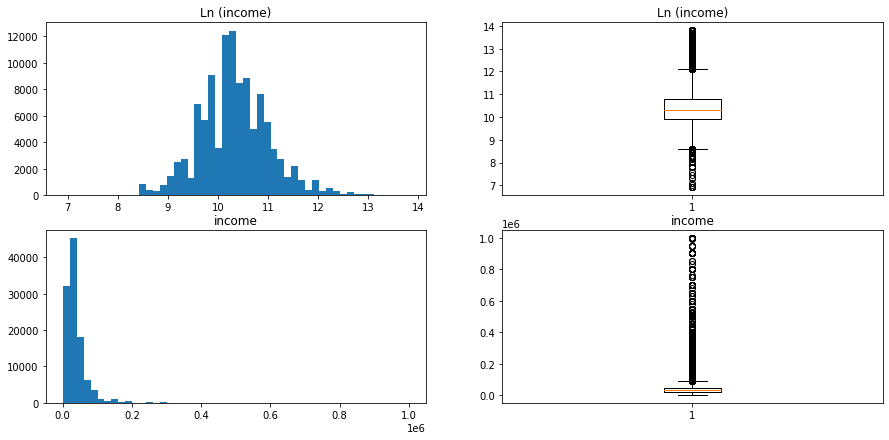

In [18]:
def plot_hist(column):
    column = column

    fig, axes = plt.subplots(2,2, figsize = (15,7))

    axes[0,0].hist(np.log(data[column]), bins = 50)
    axes[0,1].boxplot(np.log(data[column]))
    axes[0,0].set_title('Ln ('+ column +')')
    axes[0,1].set_title('Ln ('+ column +')')



    axes[1,0].hist(data[column], bins = 50)
    axes[1,1].boxplot((data[column]))
    axes[1,0].set_title(column)
    axes[1,1].set_title(column)

plot_hist('income')

Text(0.5, 1.0, 'age')

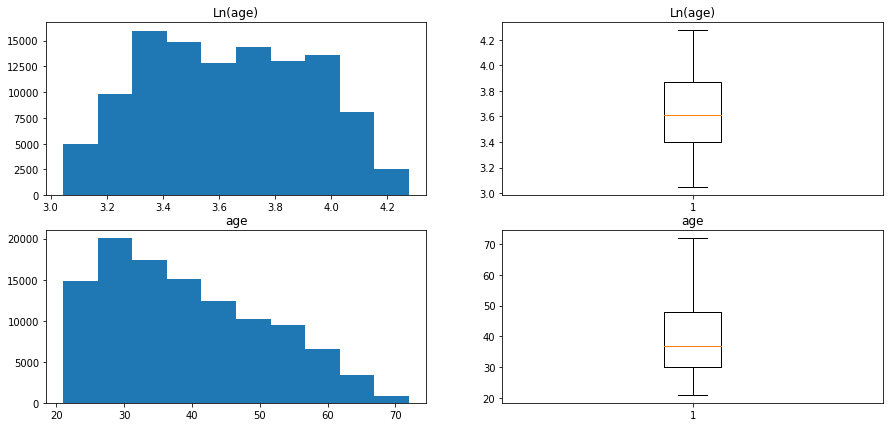

In [19]:
fig, axes = plt.subplots(2,2, figsize = (15,7))

axes[0,0].hist(np.log(data['age']), bins = 10)
axes[0,1].boxplot(np.log(data.age))
axes[0,0].set_title('Ln(age)')
axes[0,1].set_title('Ln(age)')

axes[1,0].hist(data['age'], bins = 10)
axes[1,1].boxplot((data.age))
axes[1,0].set_title('age')
axes[1,1].set_title('age')

Распределения нормальные, "с правым хвостом". Необходимо при загрузке модели выполнить стандартизацию

4. Корреляция

<AxesSubplot:>

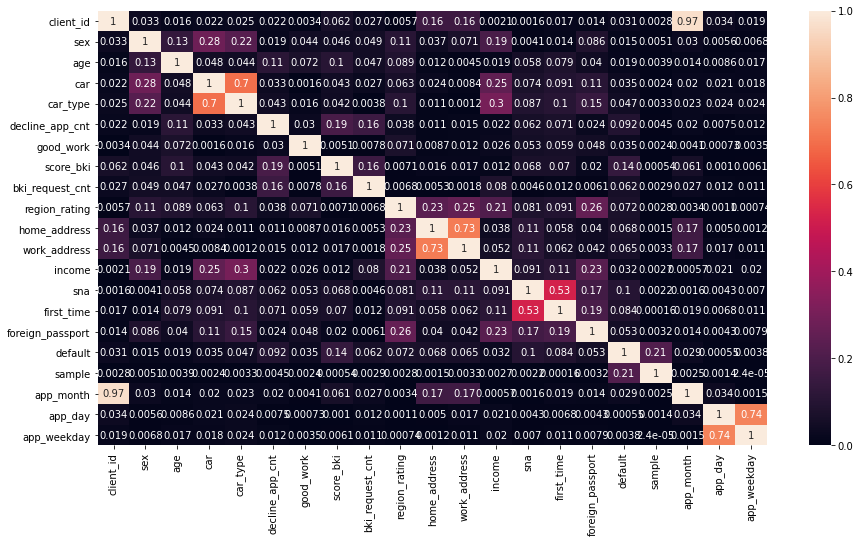

In [20]:
plt.figure(figsize = (15,8))
sns.heatmap(data.corr().abs(), vmin=0, vmax=1, annot =True)

Судя по схеме корреляции, в данных нет сильно скореллированных значений, поэтому их можно использовать в модели. Сильная скореллированность номера client_id и месяца заявки объясняемтся порядковой нумерацией id клиентов. Так как в модели не будет использоваться client_id, это не повлияет на обучаемость модели.

<AxesSubplot:>

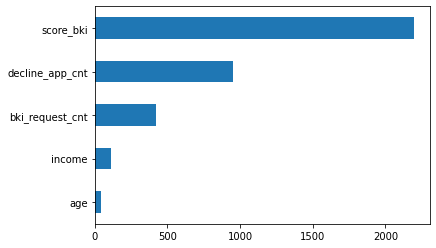

In [21]:
# Значимость номерных признаков и их влияние на признак default

imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [22]:
encoder = LabelEncoder()
data['education'] = encoder.fit_transform(data['education'])

<AxesSubplot:title={'center':'Значимость бин. и категор. переменных по Mutual_info_classif'}>

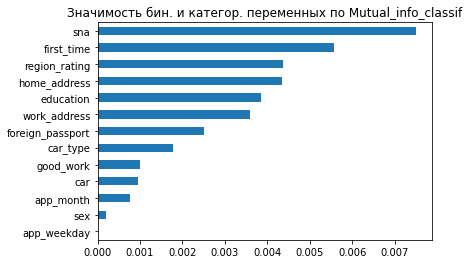

In [23]:
bin_cat_cols = cat_cols+bin_cols
bin_cat_cols = bin_cat_cols

df_train = data[data['sample']==1]

imp_cat = pd.Series(mutual_info_classif(df_train[bin_cat_cols], df_train['default'], 
                                        discrete_features =True), index = bin_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',
             title = 'Значимость бин. и категор. переменных по Mutual_info_classif')

Вывод: наиболее значимым категориальным параметром, влияющим на вероятность дефолта, является параметр sna - связь заемщика с клиентами банка, давность первого обращения клиента и рейтинг региона

5. Подготовка данных

In [24]:
# Преобразуем категориальные признаки в dummy-переменные
data = pd.get_dummies(data, columns = cat_cols)

In [25]:
# Разделим датасет обратно на train, test
train = data[data['sample']==1].drop('sample', axis = 1)
test = data[data['sample'] == 0].drop('sample',axis = 1)

# Обнулим индексы датафрейма test
train = pd.DataFrame(train.values,columns = train.columns)
test = pd.DataFrame(test.values,columns = test.columns)

In [26]:
# Стандартизируем по отдельности train, test:

scaler = StandardScaler()

train[num_cols] = pd.DataFrame(scaler.fit_transform(train[num_cols]), columns = num_cols)
test[num_cols] = pd.DataFrame(scaler.fit_transform(test[num_cols]), columns = num_cols)


In [27]:
X = train.drop(['client_id','default'], axis =1)
Y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 42)

6. Построим модель

In [28]:
train[num_cols].describe()

,decline_app_cnt,bki_request_cnt,age,income,score_bki
count,7.379900e+04,7.379900e+04,7.379900e+04,7.379900e+04,7.379900e+04
mean,-8.267468e-16,-2.011450e-15,-3.126802e-16,2.272851e-16,-4.660894e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.428577e-01,-8.882273e-01,-1.586820e+00,-8.685996e-01,-3.451961e+00
25%,-3.428577e-01,-8.882273e-01,-8.055902e-01,-4.570414e-01,-7.121447e-01
50%,-3.428577e-01,-4.441888e-01,-1.979671e-01,-2.404318e-01,-3.231314e-02
75%,-3.428577e-01,4.438880e-01,7.568691e-01,1.494655e-01,6.721673e-01
max,4.068831e+01,2.264581e+01,2.840148e+00,2.077070e+01,4.223965e+00


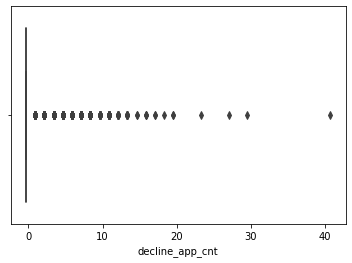

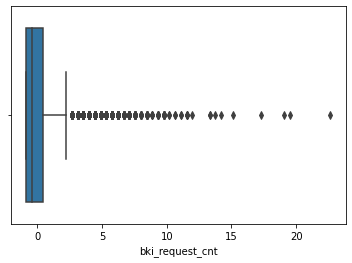

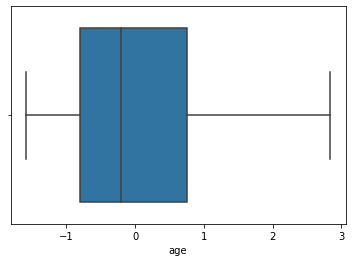

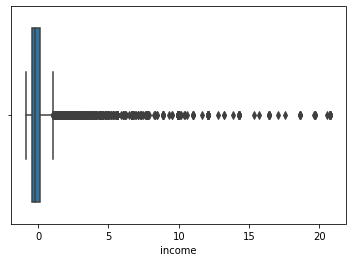

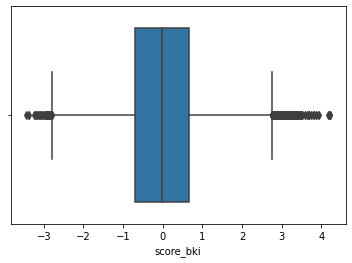

In [29]:
for col in num_cols:
    plt.figure()
    sns.boxplot(train[col])

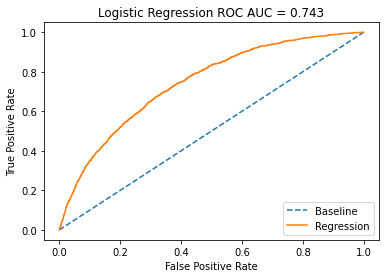

In [30]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]
y_pred = model.predict(X_test)

def plot_roc_auc(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
plot_roc_auc(y_test, probs)

Получается неплохая оценка ROC_AUC. Проверим по другим метрикам и построим confusion matrix

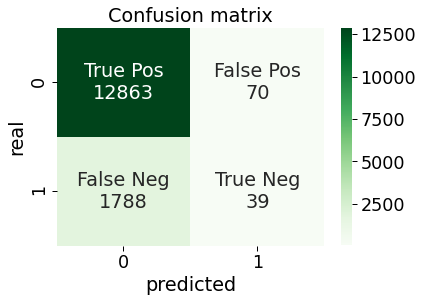

Accurracy = 0.874, 
Presision = 0.021,            
Recall = 0.358, 
F1_score = 0.04


In [31]:
# Визуализация confusion matrix:
def conf_matrix_visualize(y_test,y_pred):
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    confusion_matrix(y_test, y_pred).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Greens')
    ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
    plt.show()
    
# Визуализация других скоринговых параметров нашей модели:
def scores_plot(y_pred,y_test):
    f1 = f1_score(y_pred,y_test).round(3)
    acc = accuracy_score(y_pred,y_test).round(3)
    recall = recall_score(y_pred,y_test).round(3)
    precision = precision_score(y_pred,y_test).round(3)

    print ('Accurracy = {}, \nPresision = {}, \
           \nRecall = {}, \nF1_score = {}'.format(acc,precision,recall,f1))

conf_matrix_visualize(y_test,y_pred)
scores_plot(y_pred,y_test)

Как мы видим, F1_score очень низкий, значит что-то не так с моделью. Посмотрим confusion matrix

Модель хорошо предсказывает отрицательно дефолтных клиентов, но с нашей задачей - предсказанием дефолтных клиентов справляется очень плохо. Модель предсказала всего 39 дефолтов из 1788.

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


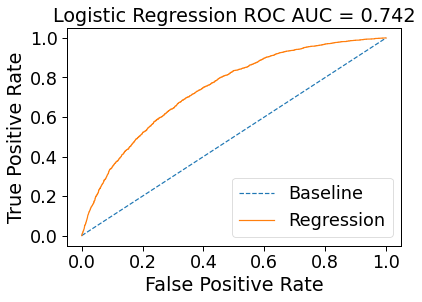

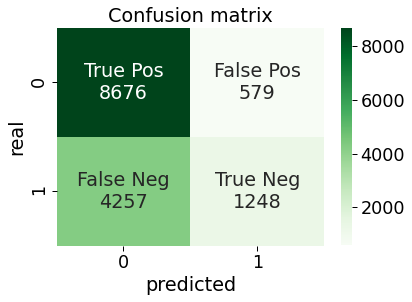

Accurracy = 0.672, 
Presision = 0.683,            
Recall = 0.227, 
F1_score = 0.34


In [32]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=42)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plot_roc_auc(y_test, probs)
conf_matrix_visualize(y_pred,y_test)
scores_plot(y_pred,y_test)

Все равно модель плохо предсказывает дефолты

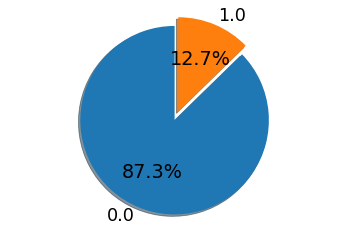

In [33]:
# Посмотрим на соотношение количества дефолтов и отсутствия дефолтов:

labels = train['default'].value_counts().index
data_val = train['default'].value_counts()
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(data_val,labels = labels, autopct='%1.1f%%',
        shadow=True, explode = explode, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Количество дефолтов слишком мало представлено в датасете. Нужно произвести undersampling данных со значением default = 0, чтобы модель лучше предсказывала значения

In [34]:
num_of_defaults = (train['default']==1).sum()
temp_df = train[train['default']==0].sample(num_of_defaults)
train_undsampled = pd.concat([temp_df,train[train['default']==1]],ignore_index=True)

train_undsampled['default'].value_counts()

0.0    9372
1.0    9372
Name: default, dtype: int64

Новый датасет после udersampling теперь поровну состоит из дефолтных и недефолтных клиентов

In [35]:
X = train_undsampled.drop(['client_id','default'], axis =1)
Y = train_undsampled['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 42)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished


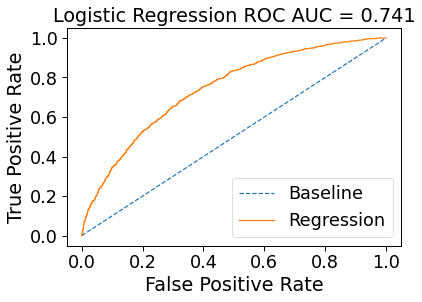

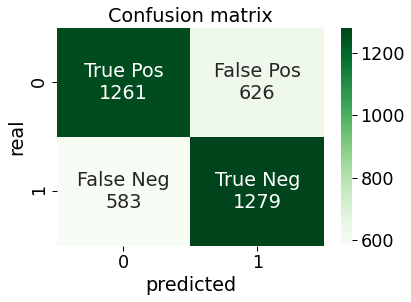

Accurracy = 0.678, 
Presision = 0.687,            
Recall = 0.671, 
F1_score = 0.679


In [36]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=42)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

plot_roc_auc(y_test, probs)
conf_matrix_visualize(y_test,y_pred)
scores_plot(y_pred,y_test)

In [37]:
print('Лучшее Penalty:', model_best.best_estimator_.get_params()['penalty'])
print('Лучшее C:', model_best.best_estimator_.get_params()['C'])
print('Лучший max_iter:', model_best.best_estimator_.get_params()['max_iter'])

Лучшее Penalty: l2
Лучшее C: 75.0
Лучший max_iter: 112


In [38]:
X_test1  = test.drop(['client_id','default'],axis=1)
probs1 = model_best.predict_proba(X_test1)[:,1]

In [39]:
test['default'] = probs1
submission = test[['client_id','default']]
submission.client_id = submission.client_id.apply(int)

In [40]:
submission.to_csv('submission.csv',index=False)